[Supervised Learning] Predictive Analysis (Regression)
-----

Explore a predictive analysis using regression models to improve user experience. Refining the re-stock strategy by considering the bike type per route, to predict the number of bikes needed at each station at different times of the day.

* Apply regression models to predict the number of bikes needed at each station at different times of the day.
* Bike type per routes, to predict the number of bikes needed at each station at different times of the day.

In [4]:
%run './feature_engineering.ipynb'

loading data to spark: divvy_df ['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']


+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+---------+----------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|start_lat| start_lng|  end_lat|   end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+---------+----------+-------------+
|00003BBE65D7BEBC| classic_bike|2023-04-27 17:50:59|2023-04-27 17:57:06|Bissell St & Armi...|    chargingstx1|Clark St & Armita...|         13146|41.918297| -87.65218|41.918304|-87.636284|       casual|
|0001F88A5226AD67|electric_bike|2023-03-20 18:02:43|2023-03-20 18:23:48|Wabash Ave & Wack...|    TA1307000131|Halsted St & 18th St|         13099|41.886753| -87.62609|41.857506| -87.64599|

loaded sampled_df_with_added_features with 43922 
 and columns ['end_station_id', 'start_station_id', 'ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual', 'start_station_name', 'end_station_name', 'day_period', 'week_day']


loaded sampled_df_with_added_features_indexed with 43922 
 and columns ['end_station_id', 'start_station_id', 'ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual', 'start_station_name', 'end_station_name', 'day_period', 'week_day', 'start_station_id_index', 'end_station_id_index', 'member_casual_index', 'day_period_index', 'week_day_index', 'rideable_type_index']


In [23]:
sampled_df_with_added_features.select('rideable_type').distinct().show()


+-------------+
|rideable_type|
+-------------+
|  docked_bike|
|electric_bike|
| classic_bike|
+-------------+



In [24]:
""" rideable_type - 0: classic_bike, 1: docked_bike, 2: electric_bike
We'll discard the docked_bike type as it's not relevant for the predictive analysis of the number of bikes needed at each station at different times of the day."""
sampled_df_with_added_features_indexed = sampled_df_with_added_features_indexed.filter(sampled_df_with_added_features['rideable_type'] != 'docked_bike')

In [25]:
# TODO - implement Regression model to predict the duration of the trip

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Filtering by workdays to reduce the data size and improve the model's performance
df_workdays = sampled_df_with_added_features_indexed.filter(sampled_df_with_added_features_indexed['week_day'] == 'Workday')
features = ['day_period_index', 'start_station_id_index', 'end_station_id_index']

# Create a VectorAssembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Initialize the GBTClassifier
log_reg = LogisticRegression(labelCol="rideable_type_index", featuresCol="features", maxIter=10, family="multinomial")

# Define the pipeline
pipeline = Pipeline(stages=[assembler, scaler, log_reg])

# Split the data into training and testing sets
(train_data, test_data) = df_workdays.randomSplit([0.8, 0.2])

# Train the model
model = pipeline.fit(train_data)

# Make predictions based on test data split
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="rideable_type_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.6310561524427326


In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Precision and Recall
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Precision: 0.5917046162075343
Recall: 0.6233582541927662


In [18]:
from pyspark.sql.functions import col

# Generate confusion matrix
confusion_matrix = predictions.groupBy('rideable_type_index').pivot('prediction', [0, 1, 2, 3]).count().na.fill(0).orderBy('rideable_type_index')
confusion_matrix.show()


+-------------------+----+---+---+---+
|rideable_type_index|   0|  1|  2|  3|
+-------------------+----+---+---+---+
|                0.0|2992| 70|  0|  0|
|                1.0|1715| 93|  0|  0|
|                2.0|  76|  3|  0|  0|
+-------------------+----+---+---+---+



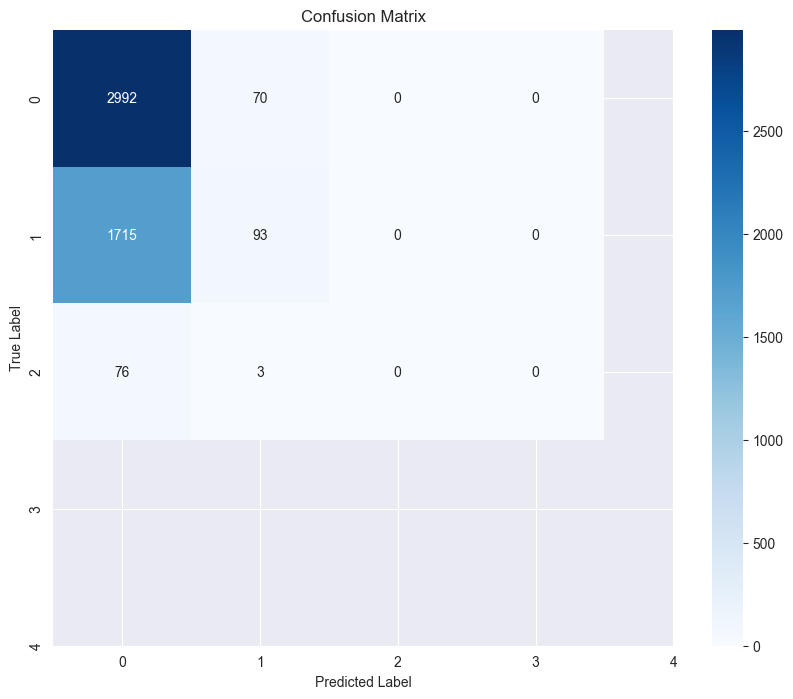

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Collect the confusion matrix data
cm_data = confusion_matrix.toPandas()
cm_data = cm_data.set_index('rideable_type_index')

# Convert to numpy for plotting
cm_array = np.array(cm_data)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(image_path,'confusion_matrix.png'))
plt.show()
